## Import Libraries

In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
import MDAnalysis as md
import torch
import pickle
from WeightedLDA import WeightedLDA as WL
from shapeGMMTorch import ShapeGMM
from shapeGMMTorch.utils import cross_validate_component_scan, sgmm_fit_with_attempts

if torch.cuda.device_count()>0:
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

output_folder = "outputs/clustering_biased"
os.makedirs(output_folder, exist_ok=True)
# if regenerate is false, clustering steps will be skipped if output files already exist
regenerate=False

In [2]:
from MDAnalysis.lib.distances import calc_dihedrals

def calc_phi_psi(trajData):
    phis = calc_dihedrals(trajData[:,0,:], trajData[:,1,:], trajData[:,2,:], trajData[:,3,:])*180/3.14
    psis = calc_dihedrals(trajData[:,1,:], trajData[:,2,:], trajData[:,3,:], trajData[:,4,:])*180/3.14
    return phis,psis

## perform cluster scan using biased simulation data 

### load trajectory from a particular simulation

In [5]:
metad_path = "/scratch/projects/hockygroup/ss12902/ShapeGMM_tutorial/run_metad"
data_path = os.path.join(metad_path,"height_0.5_bf8_sigma_0.4")
input_path = "../generate_data/inputs/"
atoms_selection = "(name C and resid 1) or (name C CA N and resid 2) or (name N and resid 3)"

top_file=  os.path.join(input_path,"alaA.pdb")
traj_files = [data_path+"/wt_metad_ld1_adp.xtc"]
print(traj_files)

univ = md.Universe(top_file, traj_files)
sel_atoms = univ.select_atoms(atoms_selection)

print("selected atom indices:", ",".join(np.array(sel_atoms.indices+1, dtype=str)))
print("Number of atoms in trajectory:", univ.atoms.n_atoms)
print("Number of frames in trajectory:", univ.trajectory.n_frames)
print("Number of atoms being analyzed:", sel_atoms.n_atoms)
print("Number of frames being analyzed:", univ.trajectory.n_frames)

trajData = np.empty((univ.trajectory.n_frames, sel_atoms.n_atoms, 3), dtype=float)
count = 0

for ts in univ.trajectory:
    trajData[count,:,:] = sel_atoms.positions - sel_atoms.center_of_geometry()
    count += 1

['/scratch/projects/hockygroup/ss12902/ShapeGMM_tutorial/run_metad/height_0.5_bf8_sigma_0.4/wt_metad_ld1_adp.xtc']
selected atom indices: 5,7,9,15,17
Number of atoms in trajectory: 22
Number of frames in trajectory: 500001
Number of atoms being analyzed: 5
Number of frames being analyzed: 500001


In [6]:
short_traj = trajData[::20]  # using every 4ps, 4x5= every 20 frames
print(short_traj.shape)

(25001, 5, 3)


### load COLVAR data as well

In [7]:
ld1, phi, psi, meta_rbias = np.loadtxt(data_path+"/COLVAR", usecols=(1,2,3,5), unpack=True)  # every 1 ps 
kt = 0.596161

wgts = np.exp(meta_rbias/kt)
wgts /= np.sum(wgts)

$\textbf{cluster scan}$

In [8]:
print(short_traj.shape, wgts[::4].shape)

(25001, 5, 3) (25001,)


In [9]:
cluster_array = np.arange(2,7).astype(int)
print(cluster_array)

[2 3 4 5 6]


In [12]:
%%time
train, cv = cross_validate_component_scan(short_traj, frame_weights=wgts[::4], train_fraction=0.90, covar_type="kronecker", 
                                          component_array = cluster_array, n_training_sets=3, n_attempts = 8, 
                                          init_component_method = "kmeans++", dtype=torch.float64, device=device)

# save
np.savetxt('train_bias.dat', train)
np.savetxt('cv_bias.dat', cv)

Number of atoms: 5
Covariance type: kronecker
Number of frames to train each model: 22500
Number of frames to predict each model: 2501
Number of training sets: 3
Number of attempts per set/component: 8
Component array: [2 3 4 5 6]
Init Component Method   : kmeans++
Random seed             : 1234
   Training Set    N Components         Attempt  Log Like per Frame Wallclock Time (s)
------------------------------------------------------------------------------------------
              1               2               1             30.9211           7.580
              1               2               2             31.0675           5.656
              1               2               3             28.9738           6.262
              1               2               4             31.0677           6.057
              1               2               5             31.0678           5.835
              1               2               6             31.0674           5.817
              1      

              3               3               5             32.4501          41.003
              3               3               6             31.6032         101.016
              3               3               7             32.4549          47.993
              3               3               8             32.4561          19.545
              3               4               1             33.2068          59.426
              3               4               2             33.2120         119.684
              3               4               3             32.6923          63.218
              3               4               4             32.8746          82.901
              3               4               5             33.0745         118.722
              3               4               6             32.8372          75.228
              3               4               7             33.2854          46.200
              3               4               8             33.0914         

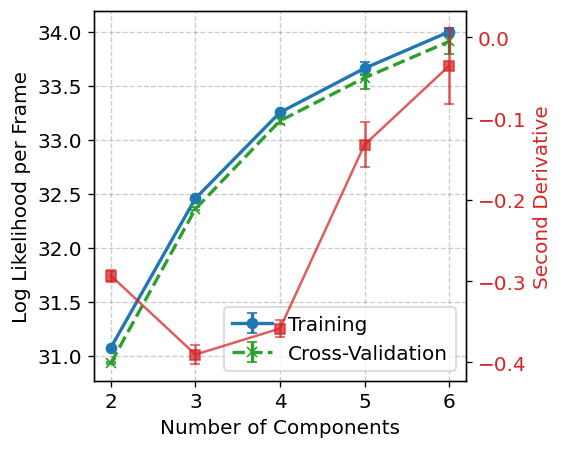

In [13]:
from shapeGMMTorch.utils import plot_log_likelihood_with_dd

train = np.loadtxt("train_bias.dat")
cv = np.loadtxt("cv_bias.dat")

# shapeGMMTorch plots has a built-in plot function for this type of plot
fig, ax = plt.subplots(1,1,figsize=(4,4), dpi= 120, facecolor='w', edgecolor='k')
plot_log_likelihood_with_dd(ax, cluster_array, train, cv, fontsize=12, ylabel1=True, ylabel2=True, xlabel=True)

$\textbf{perform ShapeGMM fit with 3 clusters}$

In [33]:
%%time
wsgmm3_bias = sgmm_fit_with_attempts(short_traj, 3, 15, init_component_method='kmeans++', frame_weights=wgts[::4], device=device, dtype=torch.float64)

with open('wsgmm3_bias.pickle', 'wb') as fo:
    pickle.dump(wsgmm3_bias, fo)

Number of components    : 3
Number of attempts      : 15
Covariance type         : kronecker
Data type (dtype)       : torch.float64
Device                  : cuda:0
Number of train frames  : 25001
Number of atoms         : 5
Init Component Method   : kmeans++
Random seed             : 1234
 Attempt  Log Like per Frame Wallclock Time (s)
------------------------------------------------------------
       1             32.4475           6.641
       2             32.3876           2.897
       3             32.4472           6.783
       4             32.4481           6.444
       5             32.4477           6.553
       6             32.4480           6.469
       7             32.4419           5.031
       8             32.3617           4.402
       9             32.4474           6.566
      10             32.4418           6.212
      11             32.4567           3.399
      12             31.6331          11.586
      13             32.3541           5.327
      14      

In [17]:
with open('wsgmm3_bias.pickle', 'rb') as fo:
    wsgmm3_bias = pickle.load(fo)

# predict
comp_ids_bias_3state = wsgmm3_bias.predict(trajData)
print(comp_ids_bias_3state.shape)

(500001,)


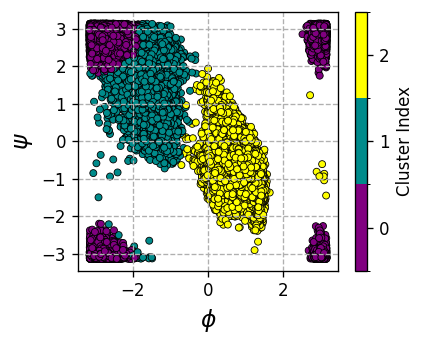

In [19]:
from matplotlib.colors import ListedColormap, BoundaryNorm

colors = ['purple', 'darkcyan', 'yellow']
cluster_boundaries = [0, 1, 2, 3]  # You need one more boundary than the number of colors
cmap = ListedColormap(colors)
norm = BoundaryNorm(cluster_boundaries, cmap.N)

plt.figure(figsize=(3.5,2.8), dpi=120)
plt.xlabel("$\phi$", fontsize=14)
plt.ylabel("$\psi$", fontsize=14)
plt.grid(axis='both', which='major', linestyle='--',)
im = plt.scatter(phi, psi, c=comp_ids_bias_3state[::5], marker='.', cmap=cmap, norm=norm, edgecolor='k', s=70, linewidths=0.5)
cbar = plt.colorbar(im, ticks=np.arange(0.5, 3, 1))
cbar.set_ticklabels(np.arange(3))
cbar.set_label('Cluster Index')

$\textbf{perform ShapeGMM fit with 4 clusters}$

In [20]:
%%time
wsgmm4_bias = sgmm_fit_with_attempts(short_traj, 4, 15, init_component_method='kmeans++', frame_weights=wgts[::4], device=device, dtype=torch.float64)

with open('wsgmm4_bias.pickle', 'wb') as fo:
    pickle.dump(wsgmm4_bias, fo)


Number of components    : 4
Number of attempts      : 15
Covariance type         : kronecker
Data type (dtype)       : torch.float64
Device                  : cuda:0
Number of train frames  : 25001
Number of atoms         : 5
Init Component Method   : kmeans++
Random seed             : 1234
 Attempt  Log Like per Frame Wallclock Time (s)
------------------------------------------------------------
       1             33.2030           6.328
       2             33.2666           5.528
       3             32.7961           8.297
       4             32.4852           8.083
       5             33.2057           6.293
       6             33.2479           7.257
       7             33.1956           6.281
       8             33.2058           6.091
       9             33.2058           6.261
      10             32.9784          10.595
      11             33.2050           5.694
      12             32.8185           4.886
      13             33.0718          14.045
      14      

In [21]:
with open('wsgmm4_bias.pickle', 'rb')as fo:
    wsgmm4_bias = pickle.load(fo)

# predict
comp_ids_bias_4state = wsgmm4_bias.predict(trajData)
print(comp_ids_bias_4state.shape)

(500001,)


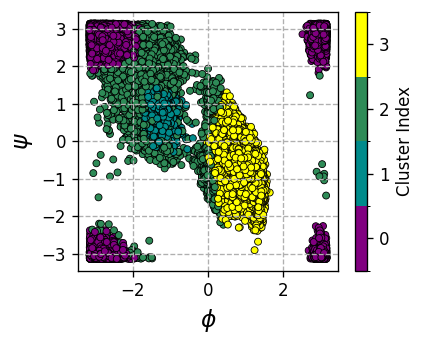

In [22]:
from matplotlib.colors import ListedColormap, BoundaryNorm

colors = ['purple', 'darkcyan', 'seagreen', 'yellow']
cluster_boundaries = [0, 1, 2, 3, 4]  # You need one more boundary than the number of colors
cmap = ListedColormap(colors)
norm = BoundaryNorm(cluster_boundaries, cmap.N)

plt.figure(figsize=(3.5,2.8), dpi=120)
plt.xlabel("$\phi$", fontsize=14)
plt.ylabel("$\psi$", fontsize=14)
plt.grid(axis='both', which='major', linestyle='--',)
im = plt.scatter(phi, psi, c=comp_ids_bias_4state[::5], marker='.', cmap=cmap, norm=norm, edgecolor='k', s=70, linewidths=0.5)
cbar = plt.colorbar(im, ticks=np.arange(0.5, 4, 1))
cbar.set_ticklabels(np.arange(4))
cbar.set_label('Cluster Index')

### Compute bhattacharya distances of new cluster centers wrt initial clusters

In [25]:
from shapeGMMTorch.utils import similarity

In [27]:
with open("outputs/clustering/wsgmm3.pickle", "rb") as fo:
    wsgmm_ref = pickle.load(fo)

print(wsgmm_ref.weights_)
print(wsgmm_ref.means_.shape)

[0.5        0.26400697 0.23599303]
(3, 5, 3)


In [28]:
wsgmm_list = [wsgmm3_bias, wsgmm4_bias]

In [29]:
dist_data = []

# loop over objects [3,4]
for i in range(2):
    
    vals = []
    # loop over number of clusters
    for j in range(wsgmm_list[i].n_components):
        
        # wrt 0
        dij_0 = similarity.bhattacharyya_distance(wsgmm_list[i], j, wsgmm_ref, 0)
        
        # wrt 1
        dij_1 = similarity.bhattacharyya_distance(wsgmm_list[i], j, wsgmm_ref, 1)
        
        vals.append([dij_0, dij_1])
        
    #dist_data.append(np.array(vals))
    dist_data.append(np.log(np.array(vals)))     # take log y


In [30]:
print(dist_data)

[array([[ 3.84573454,  2.53578128],
       [ 3.37920655, -1.01777122],
       [-0.17939779,  2.744758  ]]), array([[ 4.1233697 ,  2.38519988],
       [ 4.06143771, -0.67584795],
       [ 3.47675095,  0.97814332],
       [ 0.84251051,  3.86690085]])]


$\textbf{Plot Bhattacharyya distances for 3 clusters}$

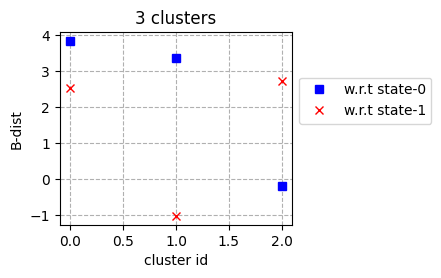

In [31]:
plt.figure(figsize=(3,2.5))
plt.xlabel("cluster id")
plt.ylabel("B-dist")
plt.grid(linestyle="--")
plt.title("3 clusters")
wsgmm = wsgmm_list[0]
for i in range(wsgmm.n_components):
    x = plt.plot(i, dist_data[0][i,0], 's', color="b", label="w.r.t state-0" if i == 0 else "")
    y = plt.plot(i, dist_data[0][i,1], 'x', color="r", label="w.r.t state-1" if i == 0 else "")
plt.legend(loc='best', bbox_to_anchor=[1.0,0.8])


$\textbf{Plot Bhattacharyya distances for 4 clusters}$

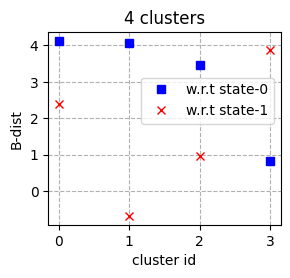

In [32]:
plt.figure(figsize=(3,2.5))
plt.xlabel("cluster id")
plt.ylabel("B-dist")
plt.grid(linestyle="--")
plt.title("4 clusters")
wsgmm = wsgmm_list[1]
for i in range(wsgmm.n_components):
    x = plt.plot(i, dist_data[1][i,0], 's', color="b", label="w.r.t state-0" if i == 0 else "")
    y = plt.plot(i, dist_data[1][i,1], 'x', color="r", label="w.r.t state-1" if i == 0 else "")
plt.legend(loc='best', bbox_to_anchor=[1.0,0.8])


### load phi-psi metad data and predict on that too ?

In [19]:
data_path = "./run_metad/bias_phi_psi"

atoms_selection = "(name C and resid 1) or (name C CA N and resid 2) or (name N and resid 3)"
top_file=  data_path + "/dialaA.pdb"
traj_files = [data_path+"/wt_metad_phi_psi_adp.xtc"]
print(traj_files)

univ = md.Universe(top_file, traj_files)
sel_atoms = univ.select_atoms(atoms_selection)

print("selected atom indices:", ",".join(np.array(sel_atoms.indices+1, dtype=str)))
print("Number of atoms in trajectory:", univ.atoms.n_atoms)
print("Number of frames in trajectory:", univ.trajectory.n_frames)
print("Number of atoms being analyzed:", sel_atoms.n_atoms)
print("Number of frames being analyzed:", univ.trajectory.n_frames)

traj_metad = np.empty((univ.trajectory.n_frames, sel_atoms.n_atoms, 3), dtype=float)
count = 0

for ts in univ.trajectory:
    traj_metad[count,:,:] = sel_atoms.positions - sel_atoms.center_of_geometry()
    count += 1

['./run_metad/bias_phi_psi/wt_metad_phi_psi_adp.xtc']
selected atom indices: 5,7,9,15,17
Number of atoms in trajectory: 22
Number of frames in trajectory: 500001
Number of atoms being analyzed: 5
Number of frames being analyzed: 500001


In [21]:
ld1_d, phi_d, psi_d, meta_rbias_d = np.loadtxt(data_path+"/COLVAR", usecols=(1,2,3,5), unpack=True)  # every 1 ps 
kt = 0.596161

wgts_d = np.exp(meta_rbias_d/kt)
wgts_d /= np.sum(wgts_d)

In [22]:
# predict cluster assignments on phi-psi metad simulation data 
comp_ids_d3 = wsgmm3_bias.predict(traj_metad)
print(comp_ids_d3.shape)

comp_ids_d4 = wsgmm4_bias.predict(traj_metad)
print(comp_ids_d4.shape)

(500001,)
(500001,)


$\textbf{predicted using 3 state wSGMM}$

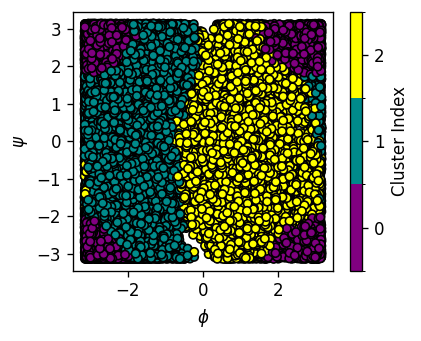

In [30]:
from matplotlib.colors import ListedColormap, BoundaryNorm

colors = ['purple', 'darkcyan', 'yellow']
cluster_boundaries = [0, 1, 2, 3]  # You need one more boundary than the number of colors
cmap = ListedColormap(colors)
norm = BoundaryNorm(cluster_boundaries, cmap.N)

fig, ax = plt.subplots(1, 1, figsize=(3.5,2.8), dpi=120)
ax.set_xlabel('$\phi$')
ax.set_ylabel('$\psi$')
im = ax.scatter(phi_d, psi_d, c=comp_ids_d3[::5], marker='o', s=25, edgecolor='k', cmap=cmap, norm=norm)
cbar = plt.colorbar(im, ticks=np.arange(0.5, 3, 1))
cbar.set_ticklabels(np.arange(3))
cbar.set_label('Cluster Index')

$\textbf{predicted using 4 state wSGMM}$

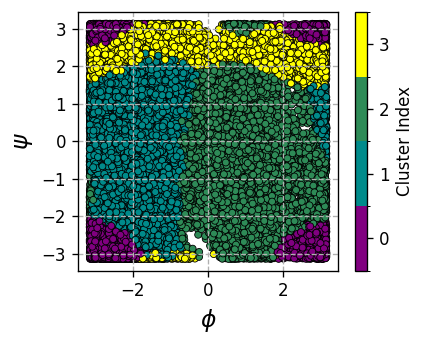

In [29]:
from matplotlib.colors import ListedColormap, BoundaryNorm

colors = ['purple', 'darkcyan', 'seagreen', 'yellow']
cluster_boundaries = [0, 1, 2, 3, 4]  # You need one more boundary than the number of colors
cmap = ListedColormap(colors)
norm = BoundaryNorm(cluster_boundaries, cmap.N)

plt.figure(figsize=(3.5,2.8), dpi=120)
plt.xlabel("$\phi$", fontsize=14)
plt.ylabel("$\psi$", fontsize=14)
plt.grid(axis='both', which='major', linestyle='--',)
im = plt.scatter(phi_d, psi_d, c=comp_ids_d4[::5], marker='.', cmap=cmap, norm=norm, edgecolor='k', s=70, linewidths=0.5)
cbar = plt.colorbar(im, ticks=np.arange(0.5, 4, 1))
cbar.set_ticklabels(np.arange(4))
cbar.set_label('Cluster Index')